# Duolingo Resurrection Forecast

## Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

/home/tavera/youtube/all_hail_the_owl/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## EDA

### Preprocessing

In [7]:
df = pd.read_csv('./data/xp_points.csv')
df.head()

,Timestamp,XP
0,2025-02-21 19:53:30,"30,493,525,909 XP"
1,2025-02-21 19:54:30,"30,499,580,080 XP"
2,2025-02-21 19:55:30,"30,505,644,282 XP"
3,2025-02-21 19:56:30,"30,511,628,307 XP"
4,2025-02-21 19:57:30,"30,517,642,372 XP"


In [8]:
df['XP'] = df['XP'].str.replace(' XP', '', regex=False) \
                 .str.replace(',', '', regex=False) \
                 .astype(int)

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.strftime('%Y-%m-%d %H:%M')

In [10]:
df.rename(columns={"Timestamp": "time"}, inplace=True)

In [11]:
df["time"] = pd.to_datetime(df["time"])


In [12]:
df["XP_growth"] = df["XP"].pct_change()
df["XP_growth"].describe()

count    1058.000000
mean        0.000165
std         0.000012
min         0.000133
25%         0.000158
50%         0.000168
75%         0.000174
max         0.000199
Name: XP_growth, dtype: float64

In [13]:
df.head()

,time,XP,XP_growth
0,2025-02-21 19:53:00,30493525909,NaN
1,2025-02-21 19:54:00,30499580080,0.000199
2,2025-02-21 19:55:00,30505644282,0.000199
3,2025-02-21 19:56:00,30511628307,0.000196
4,2025-02-21 19:57:00,30517642372,0.000197


### Plots

/tmp/ipykernel_26718/3530352024.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=10)


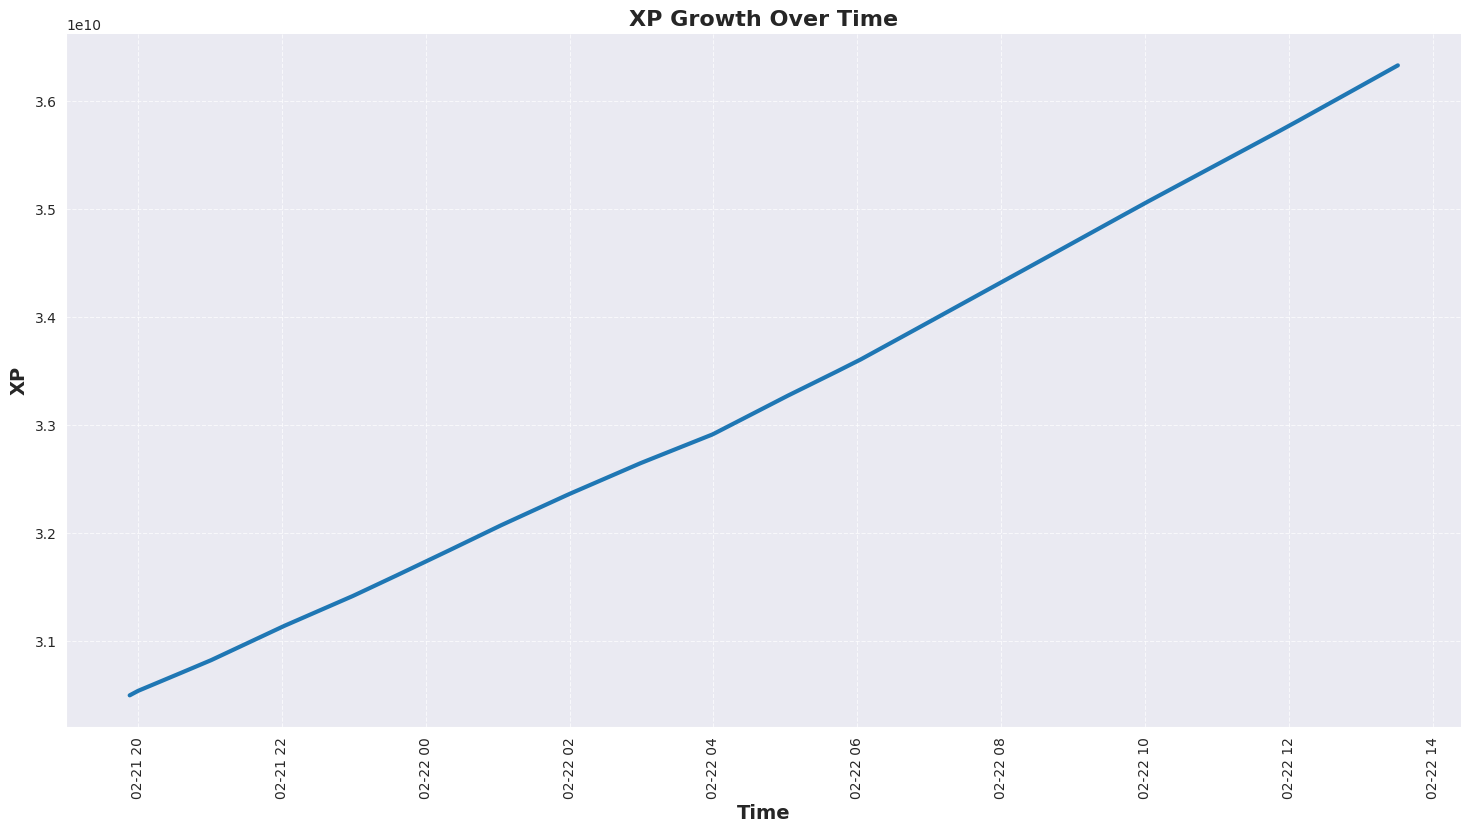

In [14]:

# Set style and color palette
sns.set_style("darkgrid")
sns.set_palette("viridis")

# Create the plot
plt.figure(figsize=(18, 9))
sns.lineplot(data=df, x="time", y="XP", linewidth=3, color="#1f77b4")

# Improve x-axis tick formatting
plt.xticks(rotation=90, fontsize=10)  
plt.locator_params(axis="x", nbins=10)  

# Customize plot aesthetics
plt.xlabel("Time", fontsize=14, fontweight='bold')
plt.ylabel("XP", fontsize=14, fontweight='bold')
plt.title("XP Growth Over Time", fontsize=16, fontweight='bold')

# Refine the grid and borders
plt.grid(True, linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)

# Show the plot
plt.show()


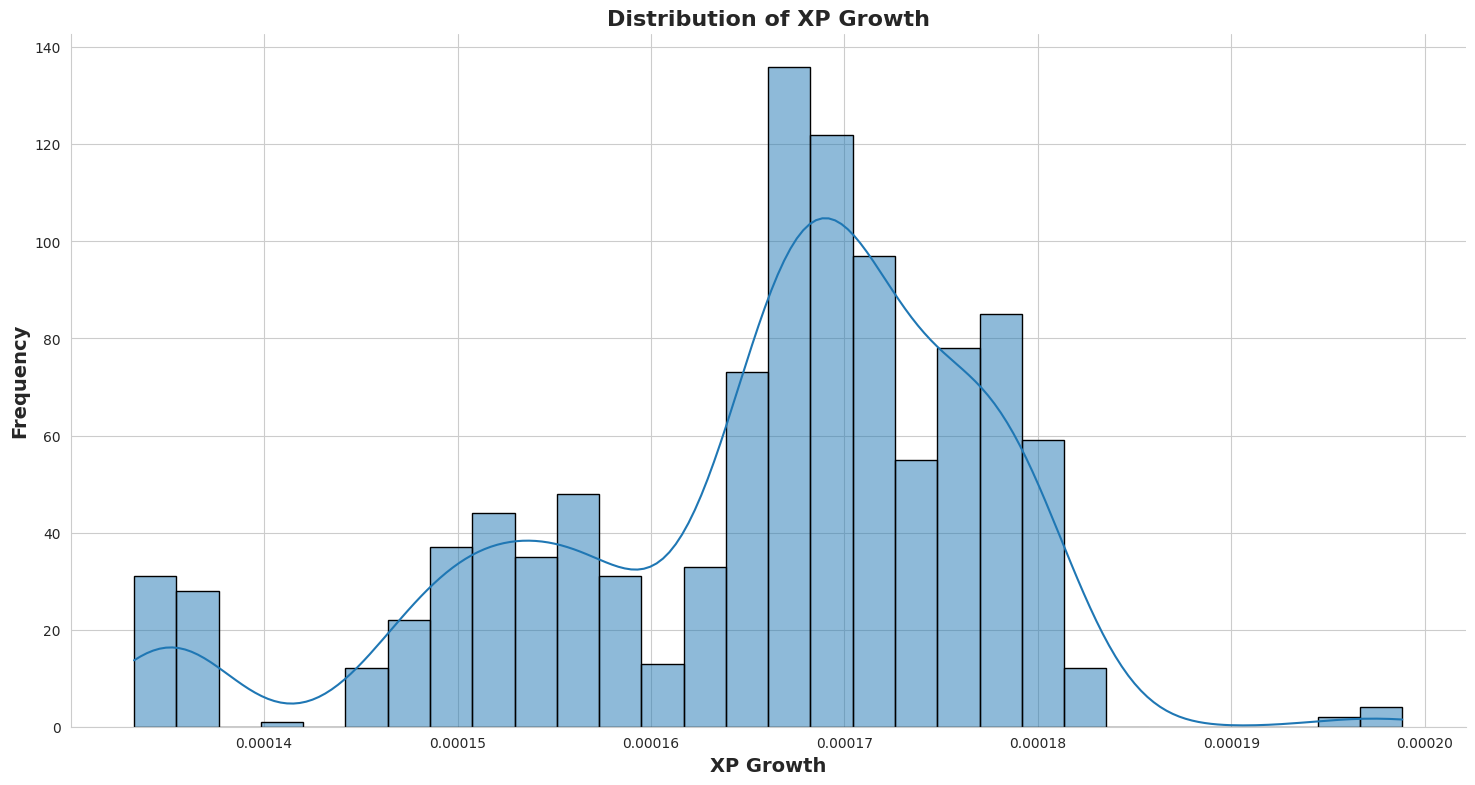

In [15]:
# Set style and color palette
sns.set_style("whitegrid")
sns.set_palette("viridis")

# Drop NaN values in XP_growth
df_filtered = df.dropna(subset=["XP_growth"])

# Create the histogram
plt.figure(figsize=(18, 9))
sns.histplot(df_filtered["XP_growth"], bins=30, kde=True, color="#1f77b4", edgecolor="black")

# Customize labels and title
plt.xlabel("XP Growth", fontsize=14, fontweight="bold")
plt.ylabel("Frequency", fontsize=14, fontweight="bold")
plt.title("Distribution of XP Growth", fontsize=16, fontweight="bold")

# Remove top and right borders for a clean look
sns.despine(top=True, right=True)

# Show the plot
plt.show()


## Forecast

### ARIMA - ADF Test

In [16]:
adf_test = adfuller(df["XP"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"P-Value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("Time series is stationary (d=0)")
    d_value = 0
else:
    print("Time series is NOT stationary (differencing needed)")
    d_value = 1

ADF Statistic: 3.9499613572291397
P-Value: 1.0
Time series is NOT stationary (differencing needed)


In [17]:
if d_value == 1:
    df["XP_diff"] = df["XP"].diff().dropna()  # First differencing
    df.dropna(inplace=True)  # Remove NaNs after differencing

    # Step 3: Re-run ADF Test on Differenced Data
    adf_test_diff = adfuller(df["XP_diff"])
    print(f"\nAfter Differencing - ADF Statistic: {adf_test_diff[0]}")
    print(f"After Differencing - P-Value: {adf_test_diff[1]}")
    if adf_test_diff[1] < 0.05:
        print("Differenced data is now stationary (d=1)")
    else:
        print("Still not stationary. Consider d=2.")
        d_value = 2


After Differencing - ADF Statistic: -1.9299693360165389
After Differencing - P-Value: 0.31809655205670906
Still not stationary. Consider d=2.


In [18]:
if d_value == 2:
    df["XP_diff_2"] = df["XP"].diff().dropna()  # First differencing
    df.dropna(inplace=True)  # Remove NaNs after differencing

    # Step 3: Re-run ADF Test on Differenced Data
    adf_test_diff = adfuller(df["XP_diff_2"])
    print(f"\nAfter Differencing - ADF Statistic: {adf_test_diff[0]}")
    print(f"After Differencing - P-Value: {adf_test_diff[1]}")
    if adf_test_diff[1] < 0.05:
        print("Differenced data is now stationary (d=2)")
    else:
        print("Still not stationary.")



After Differencing - ADF Statistic: -1.9267293602214692
After Differencing - P-Value: 0.3195931182117636
Still not stationary.


### SES and Prophet

In [19]:
future_steps = 3000
target_xp = 50_000_000_000

In [ ]:
# Fit SES Model (Additive Trend, No Seasonality)
ses_model = ExponentialSmoothing(df["XP"], trend="add", seasonal=None)
ses_fit = ses_model.fit()

# Forecast Next 3000 Minutes
ses_forecast = ses_fit.forecast(steps=future_steps)

# Generate future timestamps
time_index_future = pd.date_range(start=df["time"].iloc[-1], periods=future_steps, freq="T")
forecast_ses = pd.DataFrame({"time": time_index_future, "XP_forecast": ses_forecast.values})

# Find When XP Will Reach 50,000,000,000
closest_index = (forecast_ses["XP_forecast"] - target_xp).abs().idxmin()
ses_predicted_time = forecast_ses.loc[closest_index, "time"]


In [21]:
# Prepare Data for Prophet
prophet_df = df.rename(columns={"time": "ds", "XP": "y"})

# Initialize and Fit Prophet Model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Forecast Future XP Growth (Predict for the Next 3000 Minutes)
future = prophet_model.make_future_dataframe(periods=future_steps, freq="T")  
forecast_prophet = prophet_model.predict(future)

# Find When XP Will Reach 50,000,000,000
closest_index = (forecast_prophet["yhat"] - target_xp).abs().idxmin()
prophet_predicted_time = forecast_prophet.loc[closest_index, "ds"]


19:24:45 - cmdstanpy - INFO - Chain [1] start processing
19:24:46 - cmdstanpy - INFO - Chain [1] done processing
/home/tavera/youtube/all_hail_the_owl/venv/lib/python3.9/site-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


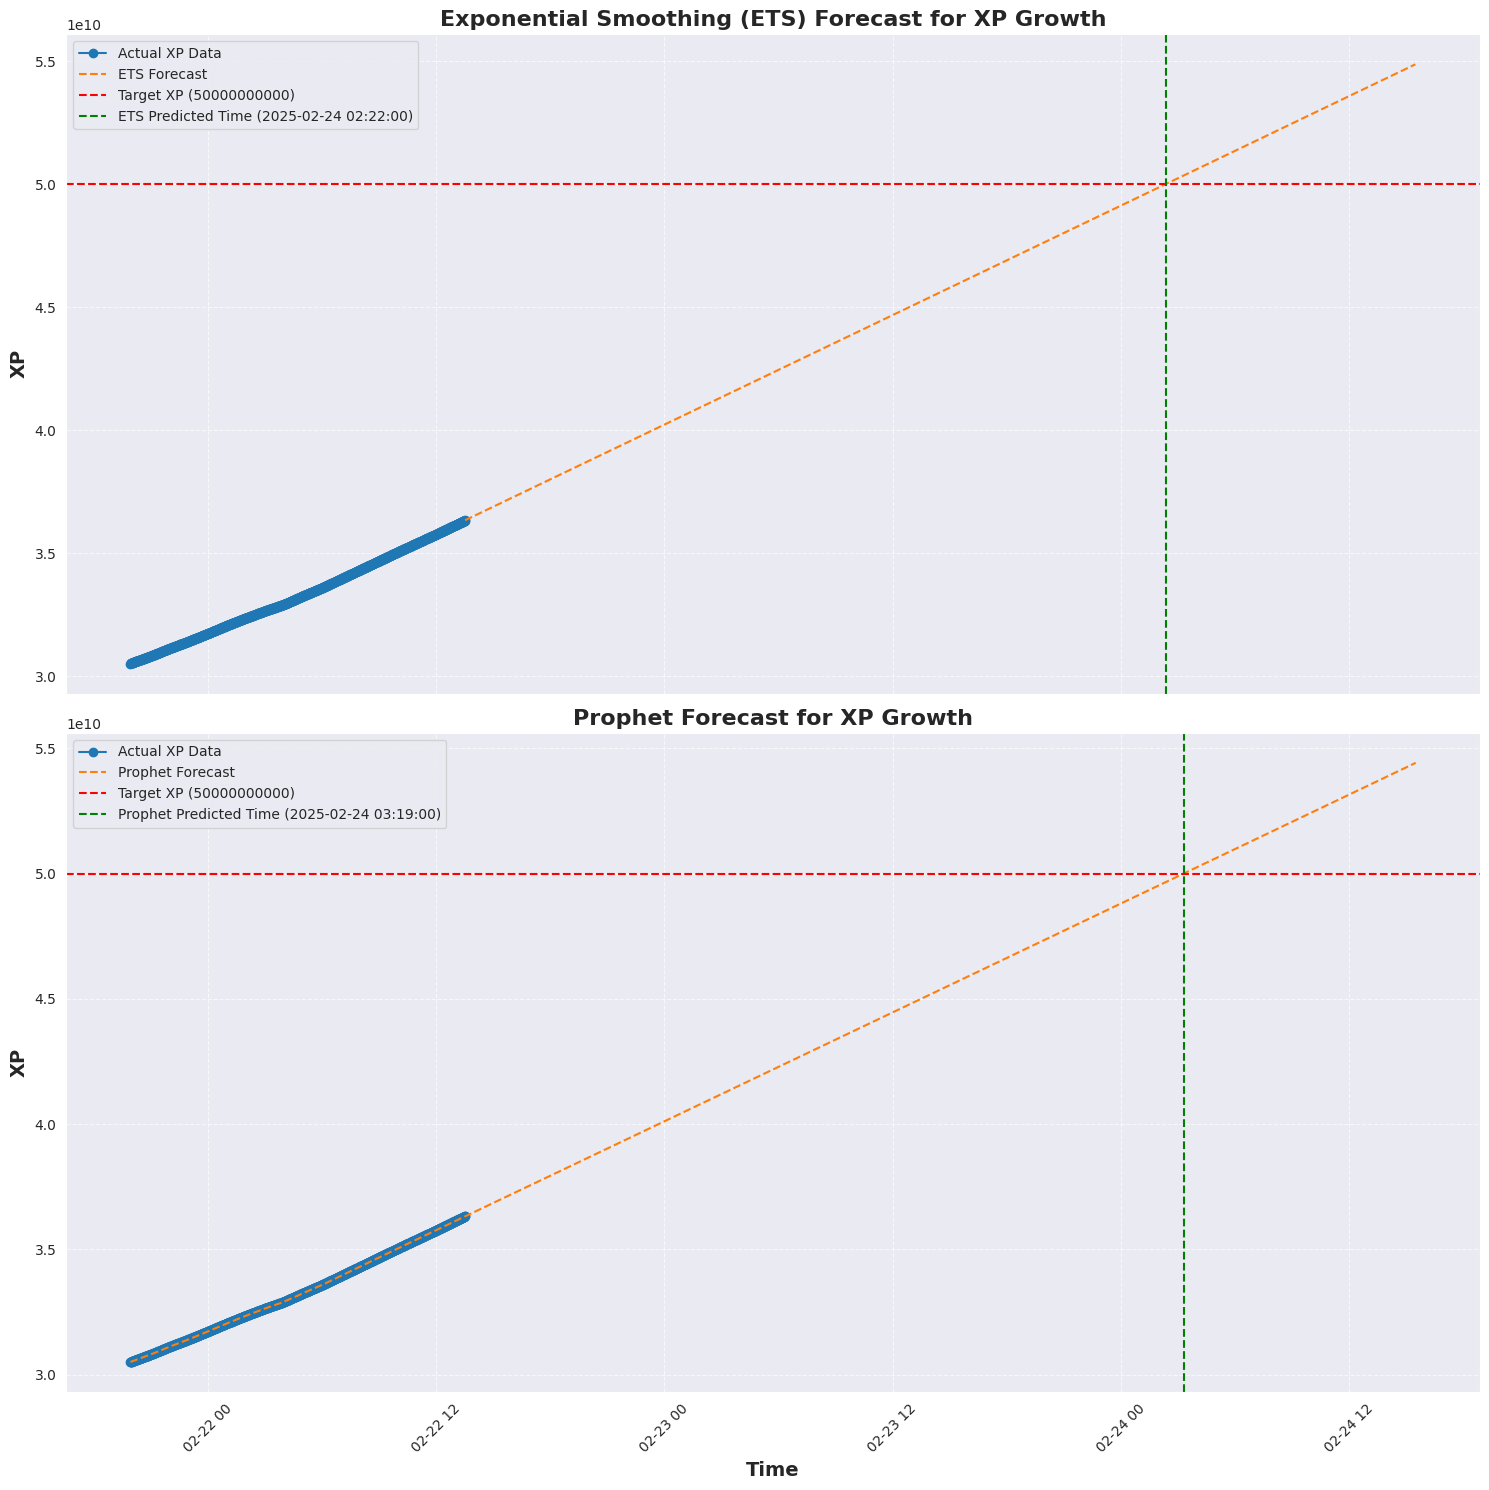

In [23]:
def plot_forecast(df: pd.DataFrame, 
                  forecast_ets: pd.DataFrame, 
                  forecast_prophet: pd.DataFrame, 
                  target_xp: int, 
                  ets_predicted_time: pd.Timestamp, 
                  prophet_predicted_time: pd.Timestamp):
    
    # Set seaborn style
    sns.set_style("darkgrid")
    sns.set_palette("viridis")

    fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

    # Plot ETS Forecast
    axes[0].plot(df["time"], df["XP"], label="Actual XP Data", marker="o", linestyle="-", color="#1f77b4")
    axes[0].plot(forecast_ets["time"], forecast_ets["XP_forecast"], label="ETS Forecast", linestyle="--", color="#ff7f0e")
    axes[0].axhline(y=target_xp, color="r", linestyle="--", label=f"Target XP ({target_xp})")
    axes[0].axvline(x=ets_predicted_time, color="g", linestyle="--", label=f"ETS Predicted Time ({ets_predicted_time})")
    axes[0].set_ylabel("XP", fontsize=14, fontweight="bold")
    axes[0].set_title("Exponential Smoothing (ETS) Forecast for XP Growth", fontsize=16, fontweight="bold")
    axes[0].legend()
    axes[0].grid(True, linestyle="--", alpha=0.7)

    # Plot Prophet Forecast
    axes[1].plot(df["time"], df["XP"], label="Actual XP Data", marker="o", linestyle="-", color="#1f77b4")
    axes[1].plot(forecast_prophet["ds"], forecast_prophet["yhat"], label="Prophet Forecast", linestyle="--", color="#ff7f0e")
    axes[1].axhline(y=target_xp, color="r", linestyle="--", label=f"Target XP ({target_xp})")
    axes[1].axvline(x=prophet_predicted_time, color="g", linestyle="--", label=f"Prophet Predicted Time ({prophet_predicted_time})")
    axes[1].set_xlabel("Time", fontsize=14, fontweight="bold")
    axes[1].set_ylabel("XP", fontsize=14, fontweight="bold")
    axes[1].set_title("Prophet Forecast for XP Growth", fontsize=16, fontweight="bold")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.7)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Call the function
plot_forecast(df, forecast_ses, forecast_prophet, target_xp, ses_predicted_time, prophet_predicted_time)
